In [39]:
%pip install h5py numpy matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

file_name = '../data_set/N-CMAPSS_DS02-006.h5'

with h5py.File(file_name, 'r') as hdf:
        data = {}
        for key in hdf.keys():
                data[key] = np.array(hdf[key])

for key in data:
        print(f"{key}" + "  : " + f"{data[key].shape}")




A_dev  : (5263447, 4)
A_test  : (1253743, 4)
A_var  : (4,)
T_dev  : (5263447, 10)
T_test  : (1253743, 10)
T_var  : (10,)
W_dev  : (5263447, 4)
W_test  : (1253743, 4)
W_var  : (4,)
X_s_dev  : (5263447, 14)
X_s_test  : (1253743, 14)
X_s_var  : (14,)
X_v_dev  : (5263447, 14)
X_v_test  : (1253743, 14)
X_v_var  : (14,)
Y_dev  : (5263447, 1)
Y_test  : (1253743, 1)


In [16]:
print(data['A_var'])
print(data['W_var'])
print(data['X_s_var'])
print(data['X_v_var'])
print(data['Y_dev'][0])
print(data['Y_dev'][100324])
print(data['Y_dev'][604832])
print(data['Y_dev'][437530])

[b'unit' b'cycle' b'Fc' b'hs']
[b'alt' b'Mach' b'TRA' b'T2']
[b'T24' b'T30' b'T48' b'T50' b'P15' b'P2' b'P21' b'P24' b'Ps30' b'P40'
 b'P50' b'Nf' b'Nc' b'Wf']
[b'T40' b'P30' b'P45' b'W21' b'W22' b'W25' b'W31' b'W32' b'W48' b'W50'
 b'SmFan' b'SmLPC' b'SmHPC' b'phi']
[74]
[66]
[22]
[35]


In [ ]:
# Finding where certain engines begin and end
print(data['A_dev'][0])
print(data['A_dev'][1000000])
print(data['A_dev'][2600000])
print(data['A_dev'][3400000])
print(data['A_dev'][4200000])
print(data['A_dev'][5263446])

print(data['A_dev'][4495287])

print(data['A_dev'][3604568])
print(data['A_dev'][3604567])

for i in range(3400000,4200000):
    if data['A_dev'][i][0] == 18:
        print(i)
        break

[2. 1. 3. 1.]
[ 5. 14.  3.  1.]
[10. 61.  3.  0.]
[16. 46.  3.  0.]
[18. 49.  3.  0.]
[20. 66.  3.  0.]
[20.  1.  3.  1.]
[18.  1.  3.  1.]
[16. 63.  3.  0.]
3604568


In [4]:
# Window Function

def create_window_features(window_array, window_size):
    features = []

    features.extend(np.mean(window_array, axis = 0))
    features.extend(np.std(window_array, axis = 0))
    features.extend(np.min(window_array, axis = 0))
    features.extend(np.max(window_array, axis = 0))

    x = np.arange(window_size)
    for j in range(window_array.shape[1]):
        slope = np.polyfit(x, window_array[:, j], 1)[0]
        features.append(slope)

    return features

In [ ]:
# We found a few best features for modeling earlier in our data exploration. Let's only extract those:
# Mach, TRA, T24, T30, T48, T50, Ps30, P40, P50, Nf, Nc, Wf
# Using these features, let's try to predict Y (RUL)
# We will use a 70-15-15 split on the W_dev and X_s_dev datasets

x_train = []
y_train = []
x_test = []
y_test = []
x_val = []
y_val = []

window_size = 30

# Disregard the 'random' - the indices were not randomly selected
# Skips first 30 vectors of each engine for windowing
random_indices = range(30,3604568) # ~70% of W_dev and X_s_dev for train  - 4 engines
random_val_indices = range(3604598, 4495287) # ~15% for validation - 1 engine
random_test_indices = range(4495317, 5263446) # ~15% for test - 1 engine
for i in random_indices:
    window = []
    for e in range(i-window_size,i):
        data_point = [data['W_dev'][i][1], data['W_dev'][i][2]]
        for e in range(5):
            data_point.append(data['X_s_dev'][i][e])
        for u in range(6):
            data_point.append(data['X_s_dev'][i][u+8])
        window.append(data_point)
    
    window = np.array(window)
    features = create_window_features(window, window_size)

    x_train.append(features)

    y_train.append(data['Y_dev'][i])

for i in random_val_indices:
    window = []
    for e in range(i-window_size,i):
        data_point = [data['W_dev'][i][1], data['W_dev'][i][2]]
        for e in range(5):
            data_point.append(data['X_s_dev'][i][e])
        for u in range(6):
            data_point.append(data['X_s_dev'][i][u+8])
        window.append(data_point)
    
    window = np.array(window)
    features = create_window_features(window, window_size)

    x_val.append(features)
    y_val.append(data['Y_dev'][i])

for i in random_test_indices:
    window = []
    for e in range(i-window_size,i):
        data_point = [data['W_dev'][i][1], data['W_dev'][i][2]]
        for e in range(5):
            data_point.append(data['X_s_dev'][i][e])
        for u in range(6):
            data_point.append(data['X_s_dev'][i][u+8])
        window.append(data_point)
    
    window = np.array(window)
    features = create_window_features(window, window_size)

    x_test.append(features)
    y_test.append(data['Y_dev'][i])

print(np.array(x_train).shape)
print(np.array(y_train).shape)

print(np.array(x_val).shape)
print(np.array(y_val).shape)

print(np.array(x_test).shape)
print(np.array(y_test).shape)

y_test = np.ravel(y_test)
y_val = np.ravel(y_val)
y_train = np.ravel(y_train)

(3604538, 65)
(3604538, 1)
(890719, 65)
(890719, 1)
(768159, 65)
(768159, 1)


In [ ]:
# To tune our parameters, we will use a random subset of the 80% training split, 
# as hardware limitations cause 

import random
indices = random.sample(range(4210711),526344)
x_train2 = []
y_train2 = []
for index in indices:
    x_train2.append(x_train[index])
    y_train2.append(y_train[index])

print(np.array(x_train).shape)
print(np.array(y_train).shape)

(4210711, 65)
(4210711,)


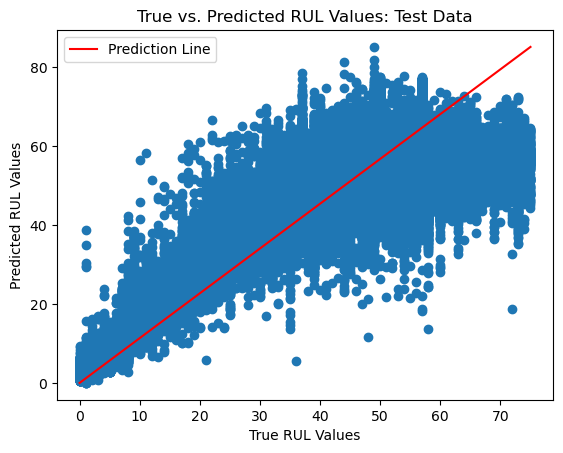

In [ ]:
# This code and chart was for a previous model trained without hyperparameter tuning.

#plt.plot([0,np.max(y_test)], [0,np.max(predicted_test_vals)], c = 'r')
#plt.legend(["Prediction Line"])
#plt.scatter(y_test, predicted_test_vals)
#plt.xlabel("True RUL Values")
#plt.ylabel("Predicted RUL Values")
#plt.title("True vs. Predicted RUL Values: Test Data")
#plt.show()

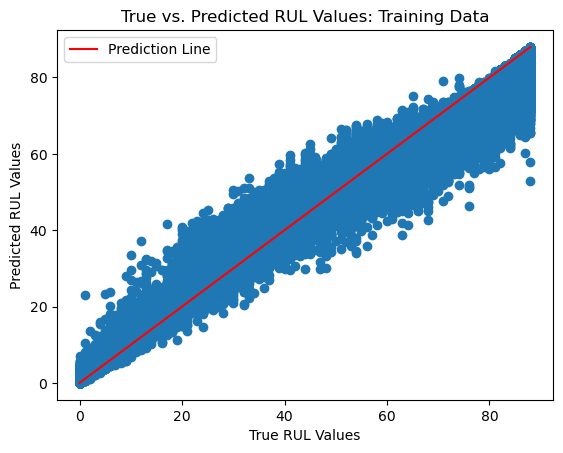

In [ ]:
# This code and chart was for a previous model trained without hyperparameter tuning.

#plt.plot([0,np.max(y_train)], [0,np.max(predicted_train_vals)], c = 'r')
#plt.legend(["Prediction Line"])
#plt.scatter(y_train, predicted_train_vals)
#plt.xlabel("True RUL Values")
#plt.ylabel("Predicted RUL Values")
#plt.title("True vs. Predicted RUL Values: Training Data")
#plt.show()

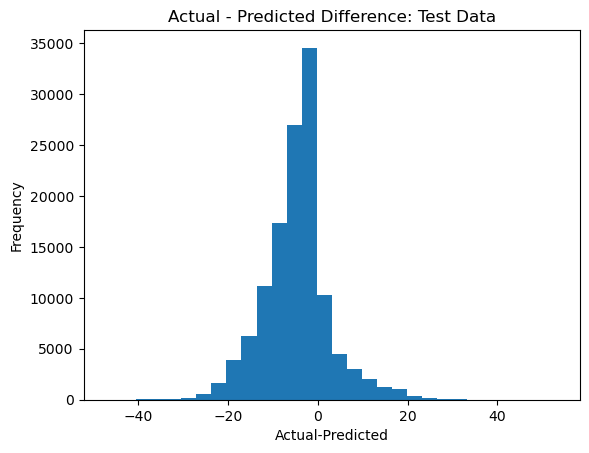

In [ ]:
# This code and chart was for a previous model trained without hyperparameter tuning.
#difs = []
#for i in range(len(y_test)):
#    dif = y_test[i] - predicted_test_vals[i]
#    difs.append(dif)

#plt.hist(difs, bins = 30)
#plt.xlabel("Actual-Predicted")
#plt.ylabel("Frequency")
#plt.title("Actual - Predicted Difference: Test Data")
#plt.show()


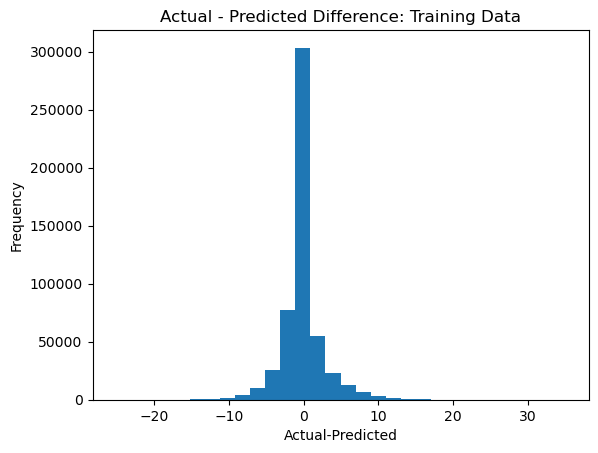

In [ ]:
# This code and chart was for a previous model trained without hyperparameter tuning.
#difs = []
#for i in range(len(y_train)):
#    dif = y_train[i] - predicted_train_vals[i]
#    difs.append(dif)

#plt.hist(difs, bins = 30)
#plt.xlabel("Actual-Predicted")
#plt.ylabel("Frequency")
#plt.title("Actual - Predicted Difference: Training Data")
#plt.show()

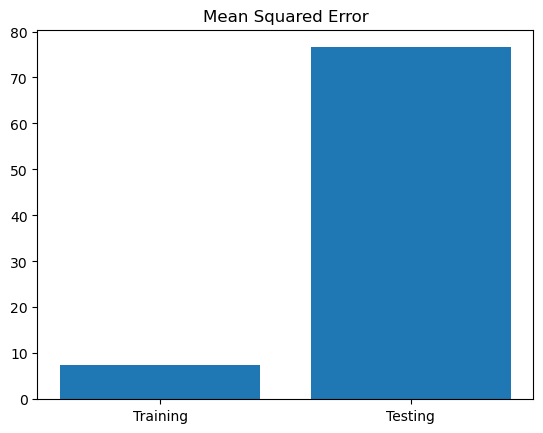

In [ ]:
# This code and chart was for a previous model trained without hyperparameter tuning.
#plt.bar(["Training","Testing"],[mse_forest_train, mse_forest_test])
#plt.title("Mean Squared Error")
#plt.show()

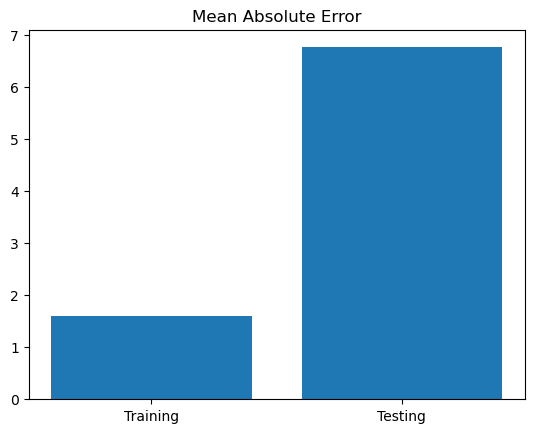

In [ ]:
# This code and chart was for a previous model trained without hyperparameter tuning.
#plt.bar(["Training","Testing"],[mae_forest_train, mae_forest_test])
#plt.title("Mean Absolute Error")
#plt.show()

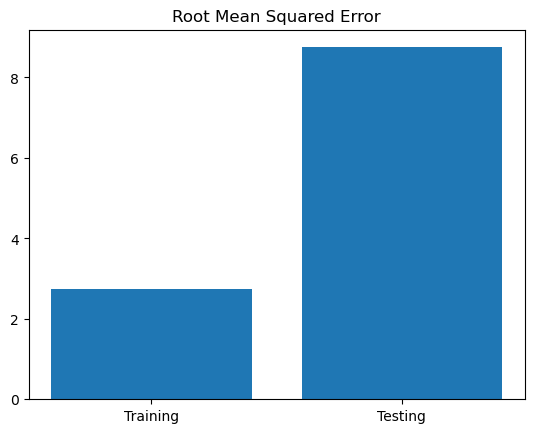

In [ ]:
# This code and chart was for a previous model trained without hyperparameter tuning.
#plt.bar(["Training","Testing"],[root_mse_forest_train, root_mse_forest_test])
#plt.title("Root Mean Squared Error")
#plt.show()

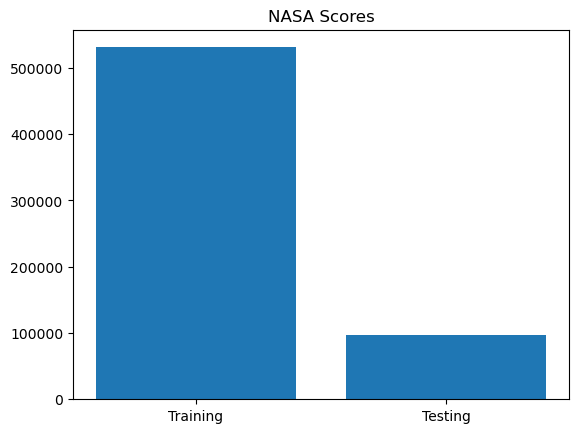

In [ ]:
# This code and chart was for a previous model trained without hyperparameter tuning.
#plt.bar(["Training","Testing"],[nasa_score_train, nasa_score_test])
#plt.title("NASA Scores")
#plt.show()

In [47]:
import sklearn.tree as tree
import sklearn.ensemble as ens

# Let's tune the max_depth parameter

depths = [5, 10, 15, 20, 25, 30, None]

predicted_train_vals = []
predicted_validation_vals = []
rmses_train = []
rmses_val = []

for depth in depths:
    forest_learner = ens.RandomForestRegressor(n_estimators = 100, criterion = 'squared_error', max_depth = depth, min_samples_leaf = 1, 
                                                max_features = 'sqrt', max_samples = 0.8)
    forest_learner.fit(x_train, y_train)
    y_val_pred = forest_learner.predict(x_val)
    y_train_pred = forest_learner.predict(x_train)
    predicted_validation_vals.append(y_val_pred)
    predicted_train_vals.append(y_train_pred)

    mse_forest_train = np.mean((y_train - y_train_pred)**2)
    mse_forest_val = np.mean((y_val - y_val_pred)**2)

    root_mse_forest_train =  np.sqrt(mse_forest_train)
    root_mse_forest_val =  np.sqrt(mse_forest_val)

    rmses_train.append(root_mse_forest_train)
    rmses_val.append(root_mse_forest_val)
    print("Max Depth: " + f"{depth}")
    print("Root Mean Squared Error Training: " + f"{root_mse_forest_train}")
    print("Root Mean Squared Error Validation: " + f"{root_mse_forest_val}")
    print()

# Best Max Depth: 25

Max Depth: 5
Root Mean Squared Error Training: 20.144083814786644
Root Mean Squared Error Validation: 18.43518866649606

Max Depth: 10
Root Mean Squared Error Training: 14.891803862270379
Root Mean Squared Error Validation: 14.082981367502216

Max Depth: 15
Root Mean Squared Error Training: 10.087662999059711
Root Mean Squared Error Validation: 10.321666058597662

Max Depth: 20
Root Mean Squared Error Training: 6.388548709348355
Root Mean Squared Error Validation: 8.35916134625105

Max Depth: 25
Root Mean Squared Error Training: 3.92257065479655
Root Mean Squared Error Validation: 7.665893015679757

Max Depth: 30
Root Mean Squared Error Training: 2.544480503457919
Root Mean Squared Error Validation: 7.572638683102213

Max Depth: None
Root Mean Squared Error Training: 1.8602432816335985
Root Mean Squared Error Validation: 7.505661744537434



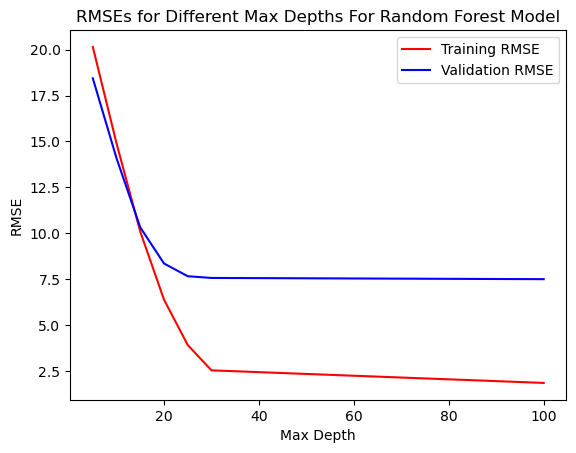

In [ ]:
rmse_train_depth = [19.65584204816392,14.91419668501566, 10.010674678339623, 6.280573943613185, 3.9565462028314013, 2.9556589981450885, 2.647491680065547]
rmse_validation_depth = [21.35484653737552, 15.42302009478594, 9.872074494670656, 7.856165055422528, 7.773429644907367, 7.935161971027226, 7.952053382195668]
depths[6] = 100 # Approximate having 'None' max_depth to 100 so it shows up
plt.plot(depths, rmses_train, c = 'r')
plt.plot(depths, rmses_val, c = 'b')
plt.legend(["Training RMSE", "Validation RMSE"])
plt.xlabel("Max Depth")
plt.ylabel("RMSE")
plt.title("RMSEs for Different Max Depths For Random Forest Model")
plt.show()

# best max_depth is None

In [ ]:
#Min Samples: 1
#Root Mean Squared Error Training: 1.8603701079767543
#Root Mean Squared Error Validation: 7.523542767367252

min_samples = [1,5,10,20,50]

# best was 20

predicted_train_vals2 = []
predicted_validation_vals2 = []

rmses_train2 = []
rmses_val2 = []

for min in min_samples:
    forest_learner = ens.RandomForestRegressor(n_estimators = 100, criterion = 'squared_error', max_depth = None, min_samples_leaf = min, 
                                                max_features = 'sqrt', max_samples = 0.8)
    forest_learner.fit(x_train, y_train)
    y_val_pred = forest_learner.predict(x_val)
    y_train_pred = forest_learner.predict(x_train)
    predicted_validation_vals2.append(y_val_pred)
    predicted_train_vals2.append(y_train_pred)

    mse_forest_train = np.mean((y_train - y_train_pred)**2)
    mse_forest_val = np.mean((y_val - y_val_pred)**2)

    root_mse_forest_train =  np.sqrt(mse_forest_train)
    root_mse_forest_val =  np.sqrt(mse_forest_val)

    rmses_train2.append(root_mse_forest_train)
    rmses_val2.append(root_mse_forest_val)

    print("Min Samples: " + f"{min}")
    print("Root Mean Squared Error Training: " + f"{root_mse_forest_train}")
    print("Root Mean Squared Error Validation: " + f"{root_mse_forest_val}")
    print()

In [14]:

# Let's tune the min_samples_leaf parameter

import sklearn.ensemble as ens

min_samples = [5,10,20,50,100,200,500]

# best was 20

predicted_train_vals = []
predicted_validation_vals = []

rmses_train = []
rmses_val = []

for min in min_samples:
    forest_learner = ens.RandomForestRegressor(n_estimators = 100, criterion = 'squared_error', max_depth = 25, min_samples_leaf = min, 
                                                max_features = 'sqrt', max_samples = 0.8)
    forest_learner.fit(x_train2, y_train2)
    y_val_pred = forest_learner.predict(x_val)
    y_train_pred = forest_learner.predict(x_train2)
    predicted_validation_vals.append(y_val_pred)
    predicted_train_vals.append(y_train_pred)

    mse_forest_train = np.mean((y_train2 - y_train_pred)**2)
    mse_forest_val = np.mean((y_val - y_val_pred)**2)

    root_mse_forest_train =  np.sqrt(mse_forest_train)
    root_mse_forest_val =  np.sqrt(mse_forest_val)

    rmses_train.append(root_mse_forest_train)
    rmses_val.append(root_mse_forest_val)

    print("Min Samples: " + f"{min}")
    print("Root Mean Squared Error Training: " + f"{root_mse_forest_train}")
    print("Root Mean Squared Error Validation: " + f"{root_mse_forest_val}")
    print()

Min Samples: 5
Root Mean Squared Error Training: 5.009104980442429
Root Mean Squared Error Validation: 7.6195360692704615

Min Samples: 10
Root Mean Squared Error Training: 5.807559934805911
Root Mean Squared Error Validation: 7.470741644516554

Min Samples: 20
Root Mean Squared Error Training: 6.714062088344503
Root Mean Squared Error Validation: 7.3913085679794035

Min Samples: 50
Root Mean Squared Error Training: 8.008876194734528
Root Mean Squared Error Validation: 7.4466966573917395

Min Samples: 100
Root Mean Squared Error Training: 9.157536989622404
Root Mean Squared Error Validation: 7.856129314604412

Min Samples: 200
Root Mean Squared Error Training: 10.360956116479894
Root Mean Squared Error Validation: 8.724580994376991

Min Samples: 500
Root Mean Squared Error Training: 12.07717790815949
Root Mean Squared Error Validation: 10.580979160299213



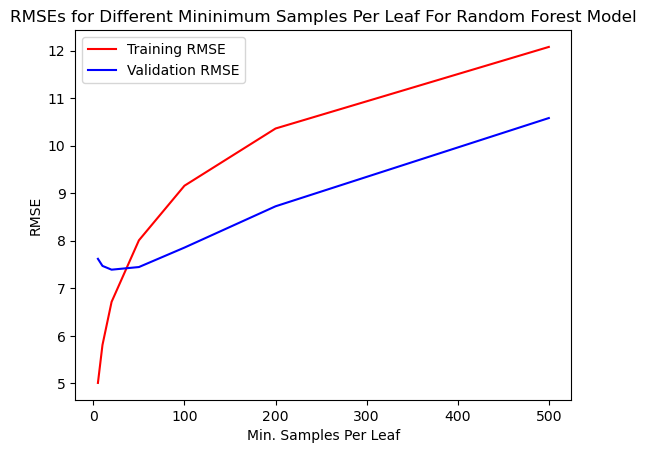

[5, 10, 15, 20, 25, 30, 100]
[np.float64(5.009104980442429), np.float64(5.807559934805911), np.float64(6.714062088344503), np.float64(8.008876194734528), np.float64(9.157536989622404), np.float64(10.360956116479894), 12.07718]
[np.float64(7.6195360692704615), np.float64(7.470741644516554), np.float64(7.3913085679794035), np.float64(7.4466966573917395), np.float64(7.856129314604412), np.float64(8.724580994376991), 10.58097]


In [ ]:
plt.plot(min_samples, rmses_train, c = 'r')
plt.plot(min_samples, rmses_val, c = 'b')
plt.legend(["Training RMSE", "Validation RMSE"])
plt.xlabel("Min. Samples Per Leaf")
plt.ylabel("RMSE")
plt.title("RMSEs for Different Mininimum Samples Per Leaf For Random Forest Model")
plt.show()
print(depths)
print(rmses_train)
print(rmses_val)

# 20 is best min_samples per leaf. However, since we will eventually train our model on a dataset 8X larger, 
# we can scale this value up later for our complete model.

In [ ]:
# Min Samples: 5
#Root Mean Squared Error Training: 10.2491895400271
#Root Mean Squared Error Validation: 10.008071678544718

#Min Samples: 20
#Root Mean Squared Error Training: 10.34334962683753
#Root Mean Squared Error Validation: 10.03224417681785

#Min Samples: 50
#Root Mean Squared Error Training: 10.508458584752567
#Root Mean Squared Error Validation: 10.219745781545452

#Min Samples: 100
#Root Mean Squared Error Training: 10.47702803339876
#Root Mean Squared Error Validation: 9.999627227788007

# Let's tune the min_samples_leaf parameter

import sklearn.ensemble as ens

min_samples = [20,160]

# best was 20

predicted_train_vals = []
predicted_validation_vals = []

rmses_train = []
rmses_val = []

for min in min_samples:
    forest_learner = ens.RandomForestRegressor(n_estimators = 100, criterion = 'squared_error', max_depth = 25, min_samples_leaf = min, 
                                                max_features = 'sqrt', max_samples = 0.8)
    forest_learner.fit(x_train, y_train)
    y_val_pred = forest_learner.predict(x_val)
    y_train_pred = forest_learner.predict(x_train)
    predicted_validation_vals.append(y_val_pred)
    predicted_train_vals.append(y_train_pred)

    mse_forest_train = np.mean((y_train - y_train_pred)**2)
    mse_forest_val = np.mean((y_val - y_val_pred)**2)

    root_mse_forest_train =  np.sqrt(mse_forest_train)
    root_mse_forest_val =  np.sqrt(mse_forest_val)

    rmses_train.append(root_mse_forest_train)
    rmses_val.append(root_mse_forest_val)

    print("Min Samples: " + f"{min}")
    print("Root Mean Squared Error Training: " + f"{root_mse_forest_train}")
    print("Root Mean Squared Error Validation: " + f"{root_mse_forest_val}")
    print()

# Just comfirming that on the larger dataset, min samples = 160 works better

Min Samples: 20
Root Mean Squared Error Training: 5.174592325056884
Root Mean Squared Error Validation: 7.839085668229659

Min Samples: 160
Root Mean Squared Error Training: 7.115336005614469
Root Mean Squared Error Validation: 7.363469061334712



In [ ]:

# Let's tune the min_samples_split parameter

import sklearn.ensemble as ens

mins_sample_split = [2, 5, 10, 20, 50]


predicted_train_split_vals = []
predicted_validation_split_vals = []

rmses_train_split = []
rmses_val_split = []

for min in mins_sample_split:
    forest_learner = ens.RandomForestRegressor(n_estimators = 100, criterion = 'squared_error', max_depth = 25, min_samples_leaf = 20, 
                                                max_features = 'sqrt', max_samples = 0.8, min_samples_split = min)
    forest_learner.fit(x_train2, y_train2)
    y_val_pred = forest_learner.predict(x_val)
    y_train_pred = forest_learner.predict(x_train2)
    predicted_validation_vals.append(y_val_pred)
    predicted_train_vals.append(y_train_pred)

    mse_forest_train = np.mean((y_train2 - y_train_pred)**2)
    mse_forest_val = np.mean((y_val - y_val_pred)**2)

    root_mse_forest_train =  np.sqrt(mse_forest_train)
    root_mse_forest_val =  np.sqrt(mse_forest_val)

    rmses_train.append(root_mse_forest_train)
    rmses_val.append(root_mse_forest_val)

    print("Min Samples: " + f"{min}")
    print("Root Mean Squared Error Training: " + f"{root_mse_forest_train}")
    print("Root Mean Squared Error Validation: " + f"{root_mse_forest_val}")
    print()

Min Samples: 2
Root Mean Squared Error Training: 6.701400155707795
Root Mean Squared Error Validation: 7.397073942387676

Min Samples: 5
Root Mean Squared Error Training: 6.6886200784117875
Root Mean Squared Error Validation: 7.377634435455986

Min Samples: 10
Root Mean Squared Error Training: 6.719913081474562
Root Mean Squared Error Validation: 7.396688728298572

Min Samples: 20
Root Mean Squared Error Training: 6.70643569722395
Root Mean Squared Error Validation: 7.369016243069743

Min Samples: 50
Root Mean Squared Error Training: 6.881259059130089
Root Mean Squared Error Validation: 7.389381837090617



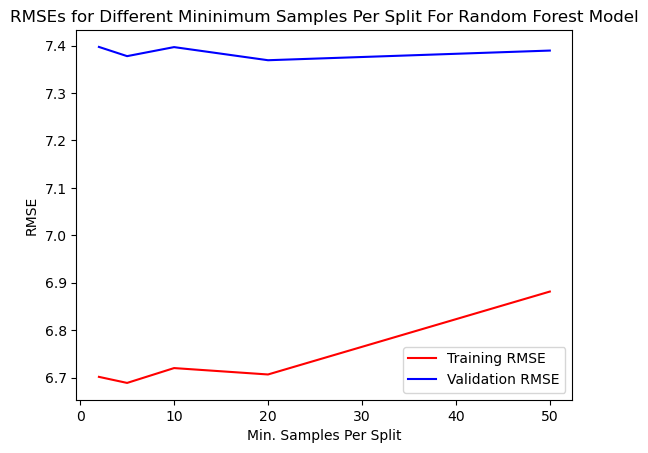

In [ ]:
rmses_val_split = [7.397073942387676,7.377634435455986,7.396688728298572,7.369016243069743,7.389381837090617]
rmses_train_split = [6.701400155707795,6.6886200784117875,6.719913081474562,6.70643569722395,6.881259059130089]

plt.plot(mins_sample_split, rmses_train_split, c = 'r')
plt.plot(mins_sample_split, rmses_val_split, c = 'b')
plt.legend(["Training RMSE", "Validation RMSE"])
plt.xlabel("Min. Samples Per Split")
plt.ylabel("RMSE")
plt.title("RMSEs for Different Mininimum Samples Per Split For Random Forest Model")
plt.show()

# Relatively minimal improvements for RMSE, but min_samples_per_split = 20 performed best
# We will also scale this up x8 once we train on the full model.

In [ ]:
# Let's tune the min_samples_split parameter

tree_nums = [100, 200, 300, 400, 500]


predicted_train_num_vals = []
predicted_validation_num_vals = []

rmses_train_num = []
rmses_val_num = []

for num in tree_nums:
    forest_learner = ens.RandomForestRegressor(n_estimators = num, criterion = 'squared_error', max_depth = 25, min_samples_leaf = 20, 
                                                max_features = 'sqrt', max_samples = 0.05, min_samples_split = 20)
    
    # Due to time limitations, I used max_samples = 0.05 to speed up the training process

    forest_learner.fit(x_train2, y_train2)
    y_val_pred = forest_learner.predict(x_val)
    y_train_pred = forest_learner.predict(x_train2)
    predicted_validation_num_vals.append(y_val_pred)
    predicted_train_num_vals.append(y_train_pred)

    mse_forest_train = np.mean((y_train2 - y_train_pred)**2)
    mse_forest_val = np.mean((y_val - y_val_pred)**2)

    root_mse_forest_train =  np.sqrt(mse_forest_train)
    root_mse_forest_val =  np.sqrt(mse_forest_val)

    rmses_train_num.append(root_mse_forest_train)
    rmses_val_num.append(root_mse_forest_val)

    print("Number of Trees: " + f"{num}")
    print("Root Mean Squared Error Training: " + f"{root_mse_forest_train}")
    print("Root Mean Squared Error Validation: " + f"{root_mse_forest_val}")
    print()

Number of Trees: 100
Root Mean Squared Error Training: 10.676622248686746
Root Mean Squared Error Validation: 8.853881246665381

Number of Trees: 200
Root Mean Squared Error Training: 10.649775391251076
Root Mean Squared Error Validation: 8.819725247330751

Number of Trees: 300
Root Mean Squared Error Training: 10.662882297569853
Root Mean Squared Error Validation: 8.828604288130057

Number of Trees: 400
Root Mean Squared Error Training: 10.645657101419253
Root Mean Squared Error Validation: 8.83576538770703

Number of Trees: 500
Root Mean Squared Error Training: 10.635527695715993
Root Mean Squared Error Validation: 8.808127482644277



In [55]:
# Initial Test on test data:


# For our final dataset, since I tuned the hyperparameters on a 10% subset of the 80% of training data, here I will increase
# the n_estimators by a factor of 1.5 and min_samples_split and min_samples_leaf by a factor of 2, as I am going to use the full 80%.

final_forest_learner = ens.RandomForestRegressor(n_estimators = 300, criterion = 'squared_error', max_depth = None, min_samples_leaf = 40, 
                                                max_features = 'sqrt', max_samples = 0.8, min_samples_split = 40)
final_forest_learner.fit(x_train, y_train)
y_val_pred_final = final_forest_learner.predict(x_val)
y_train_pred_final = final_forest_learner.predict(x_train)
y_test_pred_final = final_forest_learner.predict(x_test)

mse_forest_train_final = np.mean((y_train - y_train_pred_final)**2)
mse_forest_val_final = np.mean((y_val - y_val_pred_final)**2)
mse_forest_test_final = np.mean((y_test - y_test_pred_final)**2)

root_mse_train_final =  np.sqrt(mse_forest_train_final)
root_mse_val_final =  np.sqrt(mse_forest_val_final)
root_mse_test_final = np.sqrt(mse_forest_test_final)


KeyboardInterrupt: 

In [ ]:
#Min Samples: 1
#Root Mean Squared Error Training: 1.8603701079767543
#Root Mean Squared Error Validation: 7.523542767367252

min_samples = [1,5,10,20,50]

# best was 20

predicted_train_vals2 = []
predicted_validation_vals2 = []

rmses_train2 = []
rmses_val2 = []

for min in min_samples:
    forest_learner = ens.RandomForestRegressor(n_estimators = 100, criterion = 'squared_error', max_depth = None, min_samples_leaf = min, 
                                                max_features = 'sqrt', max_samples = 0.8)
    forest_learner.fit(x_train, y_train)
    y_val_pred = forest_learner.predict(x_val)
    y_train_pred = forest_learner.predict(x_train)
    predicted_validation_vals2.append(y_val_pred)
    predicted_train_vals2.append(y_train_pred)

    mse_forest_train = np.mean((y_train - y_train_pred)**2)
    mse_forest_val = np.mean((y_val - y_val_pred)**2)

    root_mse_forest_train =  np.sqrt(mse_forest_train)
    root_mse_forest_val =  np.sqrt(mse_forest_val)

    rmses_train2.append(root_mse_forest_train)
    rmses_val2.append(root_mse_forest_val)

    print("Min Samples: " + f"{min}")
    print("Root Mean Squared Error Training: " + f"{root_mse_forest_train}")
    print("Root Mean Squared Error Validation: " + f"{root_mse_forest_val}")
    print()

In [46]:
print(root_mse_train_final)
print(root_mse_val_final)
print(root_mse_test_final)

mae_train_final = np.mean(np.abs(y_train - y_train_pred_final))
mae_val_final = np.mean(np.abs(y_val - y_val_pred_final))
mae_test_final = np.mean(np.abs(y_test - y_test_pred_final))

print(mae_train_final)
print(mae_val_final)
print(mae_test_final)


nasa_score_train = 0
nasa_score_val = 0
nasa_score_test = 0

for i in range(len(y_train)):
    dif = y_train[i] - y_train_pred_final[i]
    if (dif>=0):
        nasa_score_train+=np.exp((1/13)*np.abs(dif))
    else:
        nasa_score_train+=np.exp((1/10)*np.abs(dif))

for i in range(len(y_val)):
    dif = y_val[i] - y_val_pred_final[i]
    if (dif>=0):
        nasa_score_val+=np.exp((1/13)*np.abs(dif))
    else:
        nasa_score_val+=np.exp((1/10)*np.abs(dif))

for i in range(len(y_test)):
    dif = y_test[i] - y_test_pred_final[i]
    if (dif>=0):
        nasa_score_test+=np.exp((1/13)*np.abs(dif))
    else:
        nasa_score_test+=np.exp((1/10)*np.abs(dif))


print(nasa_score_train)
print(nasa_score_val)
print(nasa_score_test)

7.75928449073718
8.096961392432755
10.80767750983581
5.2399898125065425
6.344459365036658
9.15901734169331
6708653.39447774
1847505.2165862997
2311192.5523449755


In [ ]:
final_forest_learner2 = ens.RandomForestRegressor(n_estimators = 300, criterion = 'squared_error', max_depth = 25, min_samples_leaf = 40, 
                                                max_features = 'sqrt', max_samples = 0.8, min_samples_split = 40)
forest_learner.fit(x_train, y_train)
y_val_pred_final = forest_learner.predict(x_val)
y_train_pred_final = forest_learner.predict(x_train)
y_test_pred_final = forest_learner.predict(x_test)